<a href="https://colab.research.google.com/github/alpellario/CancerScanAI-DesktopPredictor/blob/main/Breast-Cancer-Model-Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Struct and Training for CancerScanAI Project

CancerScanAI-App Github Link: https://github.com/alpellario/CancerScanAI-DesktopPredictor

Dataset: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
____________________

Bu veriseti ve eğitim Colab üzerinde 40gb A100 ekran kartı ve 85GM Ram kullanılarak 555bin veri üzerinde gerçekleştirilmiştir. Kişisel bilgisayarda çalıştırılırsa muhtemelen hata verir.

In [1]:
#Eğitimde kullanılacak ekran kartı bilgileri
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
# Ram bilgileri
!free -h

zsh:1: command not found: free


In [3]:
# Dataseti arşivden çıkarma ve arşivleme sırasında ilerleme cubuğunu göstermek için gerekli kütüphane
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install PyQt5

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [6]:
# this is for mac only
# %pip install tensorflow-macos

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 941.7 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.0/227.0 MB 4.6 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.8/389.8 kB 4.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 6.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 6.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 5.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
  Attempting uninstall: ml-dtypes
    Found existing installa

In [7]:
# this is to mac only
# %pip install tensorflow-metal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.2 MB/s eta 0:00:00a 0:00:010m
Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install nbformat

Note: you may need to restart the kernel to use updated packages.


In [9]:
#Model eğitimi için gerekli olan kütüphanelerin import edilmesi
import numpy as np
import pandas as pd
import bokeh.plotting as bkp
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from PIL import Image
import os
from os import listdir
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2
import random
import io
import PIL
import scipy.misc
import plotly.express as px


random.seed(100)

In [10]:
import nbformat
print(nbformat.__version__)

5.10.4


In [11]:
%pip install ipykernel

Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.


In [13]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)

GPU details:  {'device_name': 'METAL'}


In [11]:
# #Datasetin ziplenmiş halinin Google Drive'da bulunduğu konum
# sourceFile2 = '/content/drive/MyDrive/Datasets/breast-histopathology/breast-histopathology-images.zip'
# #Zip dosyasının içerisindekilerin çıkarılacağı hedef dosyası
# targetFolder2 = '/content/breast-histopathology-images'

In [12]:
# import zipfile
# import os
# from tqdm.notebook import tqdm

# #Eğer hedef dosyası yok ise oluşturmak
# if not os.path.exists(targetFolder2):
#     os.makedirs(targetFolder2)

# # Zip dosyasını açın
# with zipfile.ZipFile(sourceFile2, 'r') as zip_ref:
#     # Toplam dosya sayısını alın
#     total_files = len(zip_ref.infolist())

#     # tqdm ile ilerleme çubuğunu başlatın
#     with tqdm(total=total_files, desc="Dosyalar Çıkarılıyor") as pbar:
#         for file in zip_ref.infolist():
#             # Her dosyayı çıkarın ve ilerleme çubuğunu güncelleyin
#             zip_ref.extract(file, targetFolder2)
#             pbar.update(1)

In [15]:
#Traverses all the folders in the dataset folder recursively and collects png files.
tumor_images_path = glob.glob('archive' + '/**/*.png', recursive = True)

In [14]:
#Prints the first 5 lines of the collected dataset.
for image_path in tumor_images_path[:5]:
    print(image_path)

archive/9036/0/9036_idx5_x1051_y2401_class0.png
archive/9036/0/9036_idx5_x2951_y951_class0.png
archive/9036/0/9036_idx5_x3001_y1451_class0.png
archive/9036/0/9036_idx5_x3051_y801_class0.png
archive/9036/0/9036_idx5_x951_y1901_class0.png


In [16]:
# TODO here you want to make the code load the data in equal way
#Create separate arrays for cancerous and non-cancerous images.
healthy_images = []
tumor_images = []

#Loop through the entire dataset and separate into arrays for healthy if class is 0 and for tumors if class is 1
#The class information of image files is defined as 0 or 1 in the fifth character from the end of the image name
#example: ...9174idx5x1551y851class1.png
for image in tumor_images_path:
    if image[-5] == '0':
        healthy_images.append(image)
    elif image[-5] == '1':
        tumor_images.append(image)

healthy_count = len(healthy_images)  # Number of cancerous images
tumor_count = len(tumor_images)      # Number of non-cancerous images

total_images_count = healthy_count + tumor_count #Total number of images

print('Number of non-cancer images: {}' .format(healthy_count))
print('Number of cancer images: {}' .format(tumor_count))
print('Total number of images: {}' .format(total_images_count))

Number of non-cancer images: 397476
Number of cancer images: 157572
Total number of images: 555048


In [21]:
#
patient_data = pd.DataFrame({'Cancer Status': ['0','1'], 'Number of Patients': [397476,157572]})

patient_bar_chart = px.bar(data_frame=patient_data, x='Cancer Status', y='Number of Patients', color='Cancer Status')
patient_bar_chart.update_layout(title_text='Cancer (1) and Non-cancer (0) Number of Patients', title_x=0.5)
patient_bar_chart.show()

![](https://drive.google.com/uc?id=1ZMrKu9DBdKnbnvzCIiV41YMxPew_fRLt)

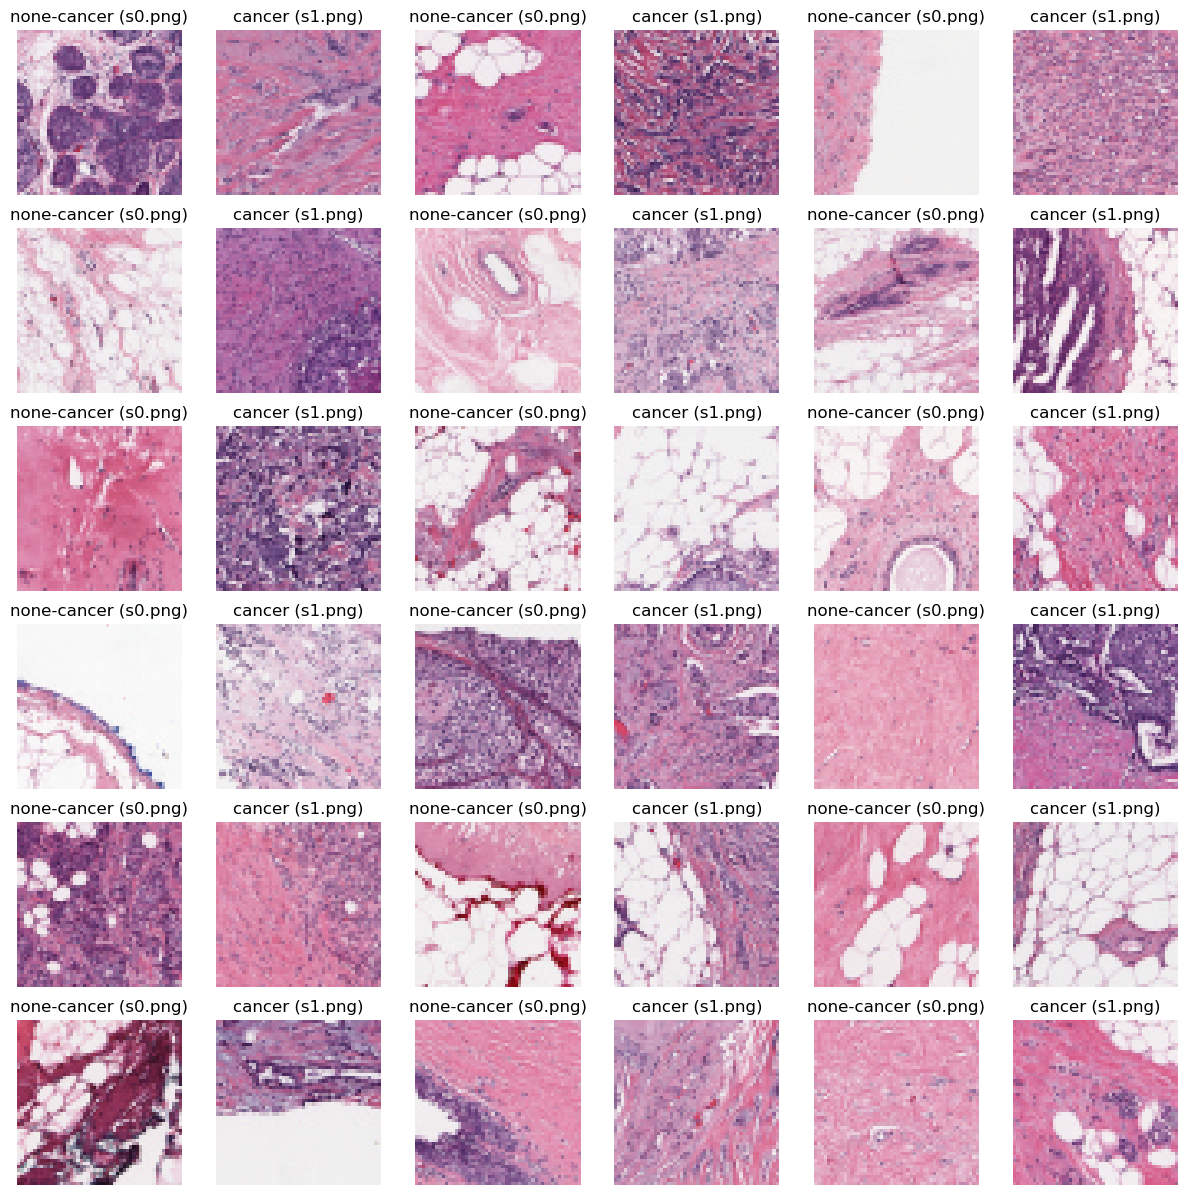

In [17]:
#Shows 18 examples each from cancerous and non-cancerous images, totaling 36 samples.

plt.figure(figsize=(15, 15))

random_healthy_samples = np.random.randint(0, len(healthy_images), 18)
random_tumor_samples = np.random.randint(0, len(tumor_images), 18)

sample_index = 0
for idx in random_healthy_samples:
    healthy_img = PIL.Image.open(healthy_images[idx])
    healthy_img_arr = np.array(healthy_img)

    plt.subplot(6, 6, 2*sample_index+1)
    plt.axis('off')
    healthy_img_name = healthy_images[idx][-6:]
    plt.title(f'none-cancer ({healthy_img_name})')
    plt.imshow(healthy_img_arr.astype('uint8'))
    sample_index += 1

sample_index = 1
for idx in random_tumor_samples:
    tumor_img = PIL.Image.open(tumor_images[idx])
    tumor_img_arr = np.array(tumor_img)

    plt.subplot(6, 6, 2*sample_index)
    plt.axis('off')
    tumor_img_name = tumor_images[idx][-6:]
    plt.title(f'cancer ({tumor_img_name})')
    plt.imshow(tumor_img_arr.astype('uint8'))
    sample_index += 1

In [18]:
sample_healthy_images = random.sample(healthy_images, len(healthy_images))
sample_tumor_images = random.sample(tumor_images, len(tumor_images))

data = []

for img in sample_healthy_images:
    img_data = cv2.imread(img, cv2.IMREAD_COLOR)
    if img_data is not None:
        img_resized = cv2.resize(img_data, (50, 50), interpolation=cv2.INTER_LINEAR)
        data.append([img_resized, 0, img])

# Loop for cancerous samples
for img in sample_tumor_images:
    img_data = cv2.imread(img, cv2.IMREAD_COLOR)
    if img_data is not None:
        img_resized = cv2.resize(img_data, (50, 50), interpolation=cv2.INTER_LINEAR)
        data.append([img_resized, 1, img])

In [23]:
# # Random samples of non-cancerous and cancerous
# sample_healthy_images = random.sample(healthy_images, len(healthy_images))
# sample_tumor_images = random.sample(tumor_images, len(tumor_images))

# # Empty arrays for image data, labels, and paths.
# healthy_data = []  # Non-cancerous image data and paths
# tumor_data = []    # Cancerous image data and paths.

# # Loop for non-cancerous samples.
# for img in sample_healthy_images:
#     img_data = cv2.imread(img, cv2.IMREAD_COLOR)
#     img_resized = cv2.resize(img_data, (50, 50), interpolation=cv2.INTER_LINEAR)
#     healthy_data.append([img_resized, 0, img])

# # Loop for cancerous samples
# for img in sample_tumor_images:
#     img_data = cv2.imread(img, cv2.IMREAD_COLOR)
#     img_resized = cv2.resize(img_data, (50, 50), interpolation=cv2.INTER_LINEAR)
#     tumor_data.append([img_resized, 1, img])

In [19]:
# Combining non-cancerous and cancerous image arrays.
# combined_data = np.concatenate((healthy_data, tumor_data))
combined_data = np.array(data, dtype=object)

In [20]:
# Shuffle combined_data randomly
random.shuffle(combined_data)

# Split back into attributes, labels, and image paths
# The structure of the dataset is very messy, so to use it in PyQt, the test and training datasets will be recreated.
image_data, labels, image_paths = zip(*combined_data)

# NumPy dizilerine dönüştürme
image_data = np.array(image_data)
labels = np.array(labels)

In [21]:
# Veri setini eğitim ve test setlerine ayırma, ayrıca yolları da bölme
X_train, X_test, y_train, y_test, X_train_paths, X_test_paths = train_test_split(image_data, labels, image_paths, test_size=0.20, random_state=42)

# Eğitim verilerini alt örnekleme oranı
subsample_rate = 0.5

# Alt örnekleme sayısı
subsample_number = int(image_data.shape[0] * subsample_rate)

# Etiketleri one-hot kodlamaya dönüştürme
y_train_encoded = to_categorical(y_train, 2)
y_test_encoded = to_categorical(y_test, 2)

print('Eğitim Verisi Boyutu: {}' .format(X_train.shape))
print('Test Verisi Boyutu: {}' .format(X_test.shape))
print('Eğitim Etiketi Boyutu: {}' .format(y_train_encoded.shape))
print('Test Etiketi Boyutu: {}' .format(y_test_encoded.shape))

Eğitim Verisi Boyutu: (444038, 50, 50, 3)
Test Verisi Boyutu: (111010, 50, 50, 3)
Eğitim Etiketi Boyutu: (444038, 2)
Test Etiketi Boyutu: (111010, 2)


In [22]:
import shutil

# Define the main directory and subdirectories for train and test datasets
prepare_dataset_path = 'train-data'
train_path = os.path.join(prepare_dataset_path, 'train')
test_path = os.path.join(prepare_dataset_path, 'test')

# Ensure these directories exist, create them if not
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Function to copy files from a list of file paths to a specified destination
def copy_files(file_paths, destination):
    for file_path in file_paths:
        shutil.copy(file_path, destination)

# Copy training and testing data to the respective directories
copy_files(X_train_paths, train_path)
copy_files(X_test_paths, test_path)


In [ ]:
# # After train_test_split, we will create the dataset for PyQt using the x_train_paths and x_test_paths corresponding to x_train and x_test.
# # Copying files to the relevant folders.
# import shutil

# prepare_dataset_path = 'train-data'
# train_path = os.path.join(prepare_dataset_path, 'train')
# test_path = os.path.join(prepare_dataset_path, 'test')

# os.makedirs(train_path, exist_ok=True)
# os.makedirs(test_path, exist_ok=True)

# # Dosyaları ilgili klasörlere kopyalama
# def copy_files(file_paths, destination):
#     for file_path in file_paths:
#         shutil.copy(file_path, destination)

# copy_files(X_train_paths, train_path)
# copy_files(X_test_paths, test_path)

# # Zipleme işlemi
# def zip_directory(folder_path, zip_path):
#     total_files = sum([len(files) for _, _, files in os.walk(folder_path)])
#     with tqdm(total=total_files, desc="Dosyalar Zipleniyor") as pbar:
#         with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
#             for root, dirs, files in os.walk(folder_path):
#                 for file in files:
#                     file_path = os.path.join(root, file)
#                     arcname = os.path.relpath(file_path, folder_path)
#                     zipf.write(file_path, arcname=arcname)
#                     pbar.update(1)
#     print(f"{zip_path} dosyası başarıyla oluşturuldu.")

# # Klasörü ziple
# zip_file_path = '/content/prepare_dataset.zip'
# zip_directory(prepare_dataset_path, zip_file_path)

In [ ]:
# #Ziplenen Dataseti Drive'a aktarma
# _drive_path = '/content/drive/MyDrive/prepare_dataset_f4.zip'
# shutil.move(zip_file_path, drive_path)

'/content/drive/MyDrive/prepare_dataset_f4.zip'

In [23]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def show_image_from_path(image_path):
    """
    Displays an image from a specified file path.
    
    Args:
    image_path (str): The file path of the image to display.
    """
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')  # Do not show axis to focus on image
    plt.show()

def show_image_from_array(image_array):
    """
    Displays an image from a numpy array.
    
    Args:
    image_array (numpy.ndarray): The numpy array of the image data.
    """
    if image_array.dtype == np.uint8:
        # If data type is uint8, it's likely properly scaled for display.
        plt.imshow(image_array)
    else:
        # Assuming the image data needs scaling to 0-255
        plt.imshow(np.uint8(255 * (image_array - np.min(image_array)) / np.ptp(image_array)))
    plt.axis('off')
    plt.show()

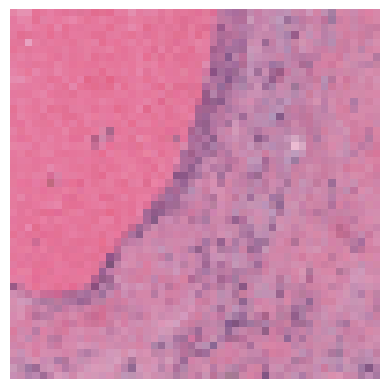

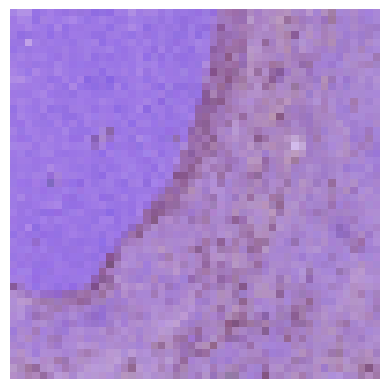

In [32]:
#Check the similarity of the contents of X_train and X_train_paths.
image_path = X_train_paths[666]
image_array = X_train[666]

# To display image from path
show_image_from_path(image_path)

# To display image from numpy array
show_image_from_array(image_array)

In [24]:
# Data augmentation to increase data (rotation, shifting, zooming, adding noise, etc
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Creating data generators for training and testing.
train_generator = data_augmentation.flow(X_train, y_train_encoded, batch_size=32)
test_generator = data_augmentation.flow(X_test, y_test_encoded, batch_size=32, shuffle=False)

In [25]:
#If the model does not show improvement during training, it allows the training to be stopped early.
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

#If the training stays on a plateau without improvement for a certain period of time, 
# that is, if the training deviates straight, it sets the function that lowers the learning rate.
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_delta=1e-7,
    cooldown=0,
    verbose=1
)

In [26]:
tf.random.set_seed(42)

# Model oluşturma
cancer_detection_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(50, 50, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(strides=2),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Modelin özetini gösterme
cancer_detection_model.summary()

# Modeli derleme
cancer_detection_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                               loss='binary_crossentropy',
                               metrics=['accuracy'])

/opt/anaconda3/envs/cnn/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,162 (1.18 MB)

 Trainable params: 307,458 (1.17 MB)

 Non-trainable params: 704 (2.75 KB)

In [27]:
#Eğitimi başlatır
training_history = cancer_detection_model.fit(X_train,
                                              y_train_encoded,
                                              validation_data=(X_test, y_test_encoded),
                                              epochs=25,
                                              batch_size=75,
                                              callbacks=[early_stop, reduce_lr_on_plateau])

Epoch 1/25
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 189s 31ms/step - accuracy: 0.9573 - loss: 0.1321 - val_accuracy: 0.9565 - val_loss: 0.1312 - learning_rate: 0.0010
Epoch 2/25
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 179s 30ms/step - accuracy: 0.9613 - loss: 0.1122 - val_accuracy: 0.9591 - val_loss: 0.1268 - learning_rate: 0.0010
Epoch 3/25
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 179s 30ms/step - accuracy: 0.9634 - loss: 0.1064 - val_accuracy: 0.9578 - val_loss: 0.1497 - learning_rate: 0.0010
Epoch 4/25
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 178s 30ms/step - accuracy: 0.9646 - loss: 0.1018 - val_accuracy: 0.9607 - val_loss: 0.1141 - learning_rate: 0.0010
Epoch 5/25
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 179s 30ms/step - accuracy: 0.9667 - loss: 0.0968 - val_accuracy: 0.9584 - val_loss: 0.1495 - learning_rate: 0.0010
Epoch 6/25
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 177s 30ms/step - accuracy: 0.9686 - loss: 0.0911 - val_accuracy: 0.9631 - val_loss: 0.1110 - learning_rate: 0.0010
Epoch 7/25
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 177s 30ms/step -

In [29]:
#Eğitilen modelin ağırlıklarını daha sonra pyqtda kullanmak için kaydetme
cancer_detection_model.save('cancer_model_detection.keras')

In [30]:
# Test verisinde modelin performansını değerlendirme
model_evaluation = cancer_detection_model.evaluate(X_test, y_test_encoded)

3470/3470 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9675 - loss: 0.0999


In [31]:
# Test verisinde tahmin yapma
predicted_values = cancer_detection_model.predict(X_test)
predicted_classes = np.argmax(predicted_values, axis=1)
true_classes = np.argmax(y_test_encoded, axis=1)


3470/3470 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


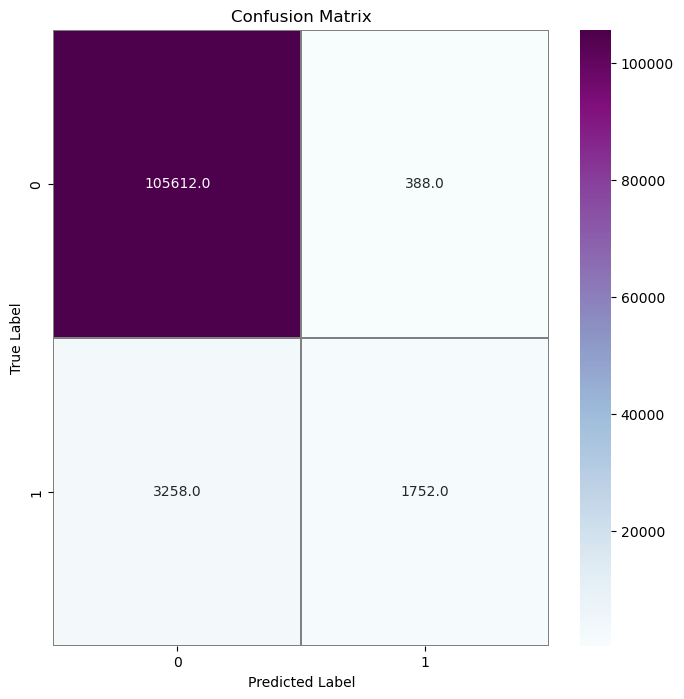

In [32]:
# Karmaşıklık matrisi oluşturma
confusion_matrix_result = confusion_matrix(true_classes, predicted_classes)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_matrix_result, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

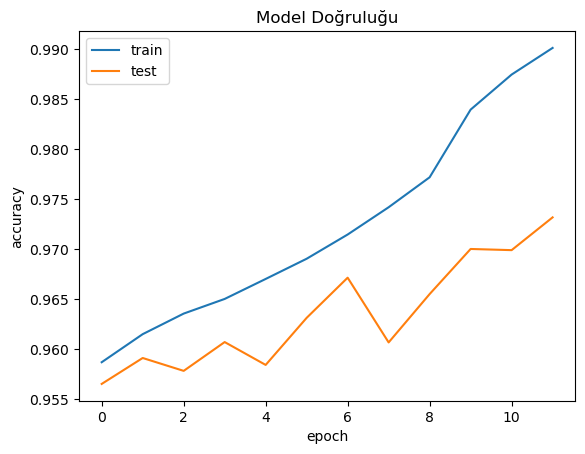

In [33]:
# Modelin doğruluk grafiğini çizme
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model Doğruluğu')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

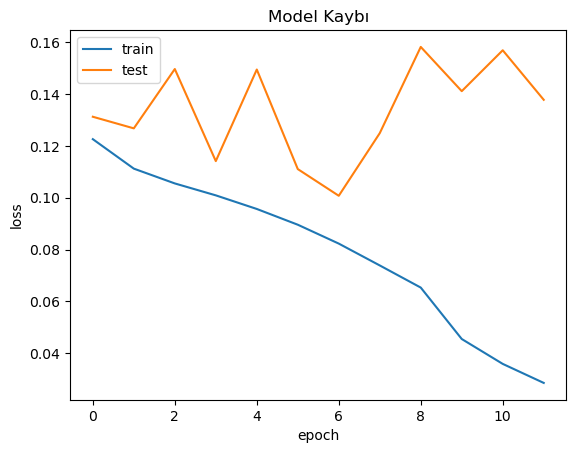

In [34]:
# Modelin kayıp grafiğini çizme
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model Kaybı')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
# Test verisinin hepsinde tahmin gerçekleştirir
predictions = cancer_detection_model.predict(X_test)
predictions

3470/3470 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


array([[9.9987733e-01, 1.2261399e-04],
       [9.9987853e-01, 1.2151789e-04],
       [9.2726135e-01, 7.2738647e-02],
       ...,
       [9.9995148e-01, 4.8467966e-05],
       [9.9569774e-01, 4.3022870e-03],
       [9.9974173e-01, 2.5825249e-04]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/

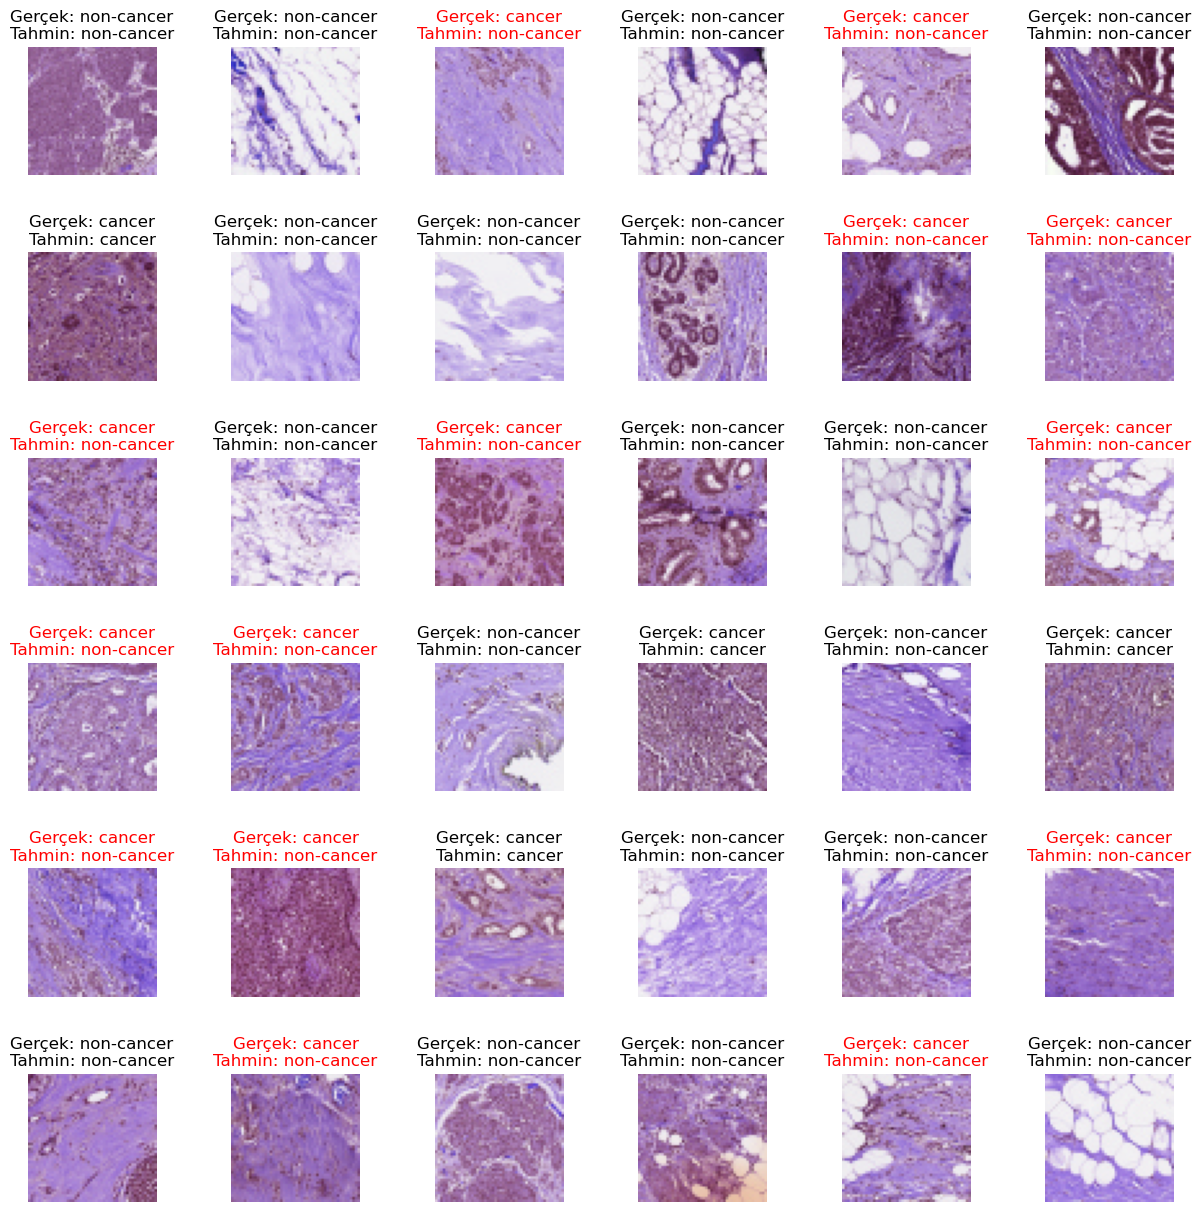

In [37]:
#Kanserli ve kansersiz görüntülerden 18 er tane toplar ve her biri üzerinde tahmin işlevi gerçekleştirip sonucu yazdırır
import matplotlib.pyplot as plt
import numpy as np

# class_labels tanımı
class_labels = {
    0: 'non-cancer',
    1: 'cancer',
}

# Kanserli ve kansersiz örneklerin indekslerini ayırma
tumor_indices = np.where(y_test_encoded.argmax(axis=1) == 1)[0]
healthy_indices = np.where(y_test_encoded.argmax(axis=1) == 0)[0]

# Her iki kategoriden eşit sayıda örnek seçme
samples_per_category = 18
selected_tumor_indices = np.random.choice(tumor_indices, samples_per_category, replace=False)
selected_healthy_indices = np.random.choice(healthy_indices, samples_per_category, replace=False)

# Seçilen indeksleri birleştirme ve karıştırma
selected_samples_indices = np.concatenate([selected_tumor_indices, selected_healthy_indices])
np.random.shuffle(selected_samples_indices)

# Seçilen örnekleri gösterme
plt.figure(figsize=(15, 15))
for i, index in enumerate(selected_samples_indices):
    sample_image = X_test[index:index+1]
    predicted_class_idx = cancer_detection_model.predict(sample_image)[0].argmax()
    true_class_idx = y_test_encoded[index].argmax()
    predicted_label = class_labels[predicted_class_idx]
    true_label = class_labels[true_class_idx]

    plt.subplot(6, 6, i+1)
    plt.imshow(X_test[index])
    title_color = 'red' if predicted_class_idx != true_class_idx else 'black'
    plt.title(f'Gerçek: {true_label}\nTahmin: {predicted_label}', color=title_color)
    plt.axis('off')

plt.subplots_adjust(hspace=0.6, wspace=0.4)
